<h2><b>pyLIQTR: QSP/QET/QSVT</b></h2>
<font size="3">

<hr>
DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

© 2023 Massachusetts Institute of Technology.

The software/firmware is provided to you on an As-Is basis

Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.
<hr><hr>
</font>

`pyLIQTR` provides different interface layers for qubitized routines.  The most user-friendly of these are presented in the Heisenberg and Fermi-Hubbard tutorials.  This notebook gives a very abbreviated presentation of lower-level access.

In [1]:

import   numpy                 as  np
import  cirq_ft                as  cirq_ft
import  cirq_ft.infra.testing  as  cirq_test

    
## Phase factors
##
from    pyLIQTR.phase_factors.phase_factors           import  PhaseFactors
from    pyLIQTR.phase_factors.named_factors           import  f_cosine, f_sine, f_exp_fourier_response

## QSP/QET/QSVT components
##
from    pyLIQTR.qubitization.qsvt                     import  QSVT_real_polynomial, QSVT_real_polynomial_sum
from    pyLIQTR.qubitization.qsvt                     import  QSP_fourier_response

## Circuit decomposition
##
from    pyLIQTR.utils.circuit_decomposition           import   circuit_decompose_multi      

## Problem instances
## 
from    pyLIQTR.ProblemInstances.getInstance          import   getInstance
from    pyLIQTR.ProblemInstances.LatticeInstance      import   LatticeInstance
from    pyLIQTR.ProblemInstances.spin_models          import   Transverse_Field_Ising
from    pyLIQTR.BlockEncodings.PauliStringLCU         import   PauliStringLCU

## Block encodings
##
from pyLIQTR.BlockEncodings.getEncoding               import   getEncoding
from pyLIQTR.BlockEncodings                           import   VALID_ENCODINGS

## Lattices
##
from   pyLIQTR.clam.lattice_definitions               import *

## Resource analysis
##
from   pyLIQTR.utils.resource_analysis                import   estimate_resources


<h3><u>2. Phase Factors</u></h3>

Phase factors for QSP/QET/QSVT are now be handled using `PhaseFactor` objects. These act like a `ProblemInstance` for specific functions that are applied to block-encoded operators:

\begin{equation}
\mathcal{O}_f: \begin{pmatrix} \Lambda & \cdot \\ \cdot & \cdot \end{pmatrix} \mapsto \begin{pmatrix} f(\Lambda) & \cdot \\ \cdot & \cdot \end{pmatrix}
\end{equation}


 The `PhaseFactors` can be passed directly to the QSVT routines, and special utilities exist for generating sets of phases. The  `Examples` directory demonstrates this  for Heisenberg and Fermi-Hubbard models. Note that phases can still be passed independent of this mechanism, and very fine-grained control can be achieved directly through the `Angler`/`Fitter`/`Expander` mechanism.

`PhaseFactor` objects are provided for the sine and cosine functions used for qubitized dynamics.  These assume an $R$-convention for phase angles, as used by QET/QSVT sequences.  Assuming a target time of $t = 30.0$ and precision target `eps=1e-6` for the Jacobi-Anger expansion and phase angle optimization:

In [2]:
t = 30.0

enc_cos = f_cosine(tau=t,eps=1e-6)
enc_sin = f_sine(tau=t,eps=1e-6)

print(enc_cos); print("\n"); print(enc_sin)

Phase angles:		cos
Expression:		$f(x) = \cos [ tau \cdot x] / 2$
# of Phases:		0
Parameters:
			tau=30.0
Convention:		R
Phase Algorithm:	Optimization
Target Precision:	1e-06
Optimizer:		Not run
Angles Computed:	False



Phase angles:		sin
Expression:		$f(x) = \sin [ tau \cdot x] / 2$
# of Phases:		0
Parameters:
			tau=30.0
Convention:		R
Phase Algorithm:	Optimization
Target Precision:	1e-06
Optimizer:		Not run
Angles Computed:	False



Note that these phases are not immediately computed by default.  This occurs when we access the angles:

In [3]:
enc_cos.phis

array([1.57079633, 1.57079633, 1.57079633, 1.57079634, 1.57079623,
       1.5707971 , 1.57079083, 1.57083105, 1.57060361, 1.57172369,
       1.56699017, 1.58383123, 1.53471088, 1.64748874, 1.45742317,
       1.659739  , 1.59100437, 1.4782391 , 1.56527034, 1.65339558,
       1.61965879, 1.53752762, 1.49341241, 1.50203464, 1.53715682,
       1.57309552, 1.59857419, 1.61245174, 1.61672394, 1.61245174,
       1.59857419, 1.57309552, 1.53715682, 1.50203464, 1.49341241,
       1.53752762, 1.61965879, 1.65339558, 1.56527034, 1.4782391 ,
       1.59100437, 1.659739  , 1.45742317, 1.64748874, 1.53471088,
       1.58383123, 1.56699017, 1.57172369, 1.57060361, 1.57083105,
       1.57079083, 1.5707971 , 1.57079623, 1.57079634, 1.57079633,
       1.57079633, 1.57079633])

Or request precomputation:

In [4]:
enc_cos = f_cosine(tau=t,eps=1e-6,precompute=True)

print(enc_cos)

Phase angles:		cos
Expression:		$f(x) = \cos [ tau \cdot x] / 2$
# of Phases:		57
Parameters:
			tau=30.0
Convention:		R
Phase Algorithm:	Optimization
Target Precision:	1e-06
Optimizer:		Success
Angles Computed:	True



We can also save time by generating the correct number of random angles, which is often sufficient for resource estimation (via `phase_algorithm='random'`):

In [5]:
enc_cos = f_cosine(tau=t,eps=1e-6,precompute=True,phase_algorithm='random')

print(enc_cos)

Phase angles:		cos
Expression:		$f(x) = \cos [ tau \cdot x] / 2$
# of Phases:		57
Parameters:
			tau=30.0
Convention:		R
Phase Algorithm:	random
Target Precision:	1e-06
Angles Computed:	True



The underlying Chebyhev polynomial expansions computed using an expansion-based method (as opposed to Remez-based fitting).  The quality of this expansion can be accessed as follows (the red line denotes the accuracy target):

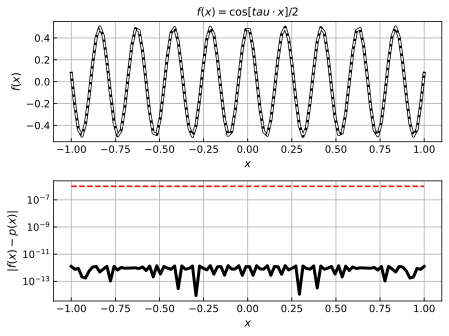

In [6]:
enc_cos.plot_expansion_error()

There is also a placeholder for legacy, Fourier-response based phases (which follow the $W_z$ convention).  However, the underlying phase-angle generation scheme has been deprecated.  This currently returns a set of random phases, and the number of these phases would be sufficient to meet accuracy thresholds, assuming an actual calculation.


In [7]:
enc_exp = f_exp_fourier_response(tau=t,eps=1e-6,precompute=True)
print(enc_exp)

Phase angles:		exp
Expression:		$f(x) = \exp[i tau x]$
# of Phases:		109
Parameters:
			tau=30.0
Convention:		fr
Phase Algorithm:	random
Target Precision:	1e-06
Angles Computed:	True



  <hr>

<h3><u>3. QSP/QET/QSVT Sequences</u></h3>

`pyLIQTR` provides a dedicated `cirq_ft` gate for QSVT sequences that are specified for real polynomials according to the $R$ phase convention.  We can demonstrate this by building $U(t) = \cos(H \cdot t)$ for the transverse-field Ising Hamiltonian  $H$ on a square lattice:

In [8]:
model            =   Transverse_Field_Ising(shape=(2,2),cell=SquareLattice)

Since the Hamiltonian is normalzied as $H \mapsto H/\alpha$ we must rescale the time as $t \mapsto \alpha \cdot H$.  This
 gives phases:

In [9]:
t = 1.0*model.alpha

enc_cos = f_cosine(tau=t,eps=1e-6,precompute=True)
enc_sin = f_sine(tau=t,eps=1e-6,precompute=True)

We build the gate as:

In [10]:
gate_cos         =  QSVT_real_polynomial(PauliStringLCU,instance=model,phis=enc_cos)

The resource overhead is:

In [11]:
estimate_resources(gate_cos)

{'LogicalQubits': 8, 'T': 46685, 'Clifford': 96487}

With circuit structure:

In [12]:
circuit_decompose_multi(gate_cos.circuit,2)

phase: ────────H───X───Rz(0.5π)───X───Z───────────────────────────────────────────────────────X───Rz(0.5π)───X───Z───────────────────────────────────────────────────────X───Rz(0.5π)───X───Z───────────────────────────────────────────────────────X───Rz(0.5π)───X───Z───────────────────────────────────────────────────────X───Rz(0.5π)───X───Z───────────────────────────────────────────────────────X───Rz(0.5π)───X───Z───────────────────────────────────────────────────────X───Rz(0.5π)───X───Z───────────────────────────────────────────────────────X───Rz(0.498π)───X───Z───────────────────────────────────────────────────────X───Rz(0.51π)───X───Z───────────────────────────────────────────────────────X───Rz(0.462π)───X───Z───────────────────────────────────────────────────────X───Rz(0.556π)───X───Z───────────────────────────────────────────────────────X───Rz(0.518π)───X───Z───────────────────────────────────────────────────────X───Rz(0.481π)───X───Z───────────────────────────────────────────────────────X───Rz(0.471π)───X───Z───────────────────────────────────────────────────────X───Rz(0.481π)───X───Z───────────────────────────────────────────────────────X───Rz(0.518π)───X───Z───────────────────────────────────────────────────────X───Rz(0.556π)───X───Z───────────────────────────────────────────────────────X───Rz(0.462π)───X───Z───────────────────────────────────────────────────────X───Rz(0.51π)───X───Z───────────────────────────────────────────────────────X───Rz(0.498π)───X───Z───────────────────────────────────────────────────────X───Rz(0.5π)───X───Z───────────────────────────────────────────────────────X───Rz(0.5π)───X───Z───────────────────────────────────────────────────────X───Rz(0.5π)───X───Z───────────────────────────────────────────────────────X───Rz(0.5π)───X───Z───────────────────────────────────────────────────────X───Rz(0.5π)───X───Z───────────────────────────────────────────────────────X───Rz(0.5π)───X───Z───────────────────────────────────────────────────────X───Rz(0.5π)───X───H───
                   │              │                                                           │              │                                                           │              │                                                           │              │                                                           │              │                                                           │              │                                                           │              │                                                           │                │                                                           │               │                                                           │                │                                                           │                │                                                           │                │                                                           │                │                                                           │                │                                                           │                │                                                           │                │                                                           │                │                                                           │                │                                                           │               │                                                           │                │                                                           │              │                                                           │              │                                                           │              │                                                           │              │                                                           │              │                                                           │              │                                                 

The "sumation" of sine and cosine terms is provided by a separate gate:

In [13]:
gate_dynamics = QSVT_real_polynomial_sum(PauliStringLCU,instance=model,phis=(enc_cos,enc_sin))


Resource overhead:

In [14]:
estimate_resources(gate_dynamics)

{'LogicalQubits': 9, 'T': 95373, 'Clifford': 197471}

Circuit structure:

In [15]:
circuit_decompose_multi(gate_dynamics.circuit,2)

┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐                                   ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐               ┌───────────────┐
control: ──────H───Rz(0.50π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.51π)─────PauliStringLCU────Rz(0.46π)─────PauliStringLCU────Rz(0.56π)─────PauliStringLCU────Rz(0.52π)─────PauliStringLCU────Rz(0.48π)─────PauliStringLCU────Rz(0.47π)─────PauliStringLCU────Rz(0.48π)─────PauliStringLCU────Rz(0.52π)─────PauliStringLCU────Rz(0.56π)─────PauliStringLCU────Rz(0.46π)─────PauliStringLCU────Rz(0.51π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.50π)───────────Rz(0.50π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.48π)─────PauliStringLCU────Rz(0.55π)─────PauliStringLCU────Rz(0.47π)─────PauliStringLCU────Rz(0.45π)─────PauliStringLCU────Rz(0.46π)─────PauliStringLCU────Rz(0.46π)─────PauliStringLCU────Rz(0.45π)─────PauliStringLCU────Rz(0.47π)─────PauliStringLCU────Rz(0.55π)─────PauliStringLCU────Rz(0.48π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.50π)─────PauliStringLCU────Rz(0.50π)───H───
                   │             │                 │             │                 │             │                 │             │                 │             │                 │             │                 │             │                 │             │                 │             │                 │             │                 │             │                 │             │                 │             │                 │             │                 │             │                 │             │                 │             │

There are separate boolean flags for adding an $S$ or a $Z$ gate on the ancilla between the controlled sine and cosine operations (`ctl_z_gate` and `ctl_s_gate`).  The use of these is contingent on the phase convention, encoding phase convention, etc. 

Finally, we continue to provide `pyLIQTR`'s legacy Fourier-response sequence.  While this appears to have an advantage in $T$-complexity for small circuits, this overhead is diminished at scale.  The legacy method also has nontrivial issues when computing phase angles to the precisiion required for many utility-scale problems.

In [16]:
enc_exp = f_exp_fourier_response(tau=t,eps=1e-6,precompute=True)
print(enc_exp)

Phase angles:		exp
Expression:		$f(x) = \exp[i tau x]$
# of Phases:		45
Parameters:
			tau=8.0
Convention:		fr
Phase Algorithm:	random
Target Precision:	1e-06
Angles Computed:	True



In [17]:
qsp_wz_gate         =  QSP_fourier_response(PauliStringLCU,enc_exp,instance=model)


In [18]:
estimate_resources(qsp_wz_gate)

{'LogicalQubits': 8, 'T': 42843, 'Clifford': 91015}

In [19]:
circuit_decompose_multi(qsp_wz_gate.circuit,2)

phase: ────────Rx(0.449π)──────────@───────────────Ry(0.754π)───@──────────────────────────────────────@───Rx(0.819π)───@───────────────────────@───────────────Ry(0.709π)───@──────────────────────────────────────@───Rx(0.733π)───@───────────────────────@───────────────Ry(0.326π)───@──────────────────────────────────────@───Rx(0.494π)───@───────────────────────@───────────────Ry(0.96π)───@──────────────────────────────────────@───Rx(0.231π)───@───────────────────────@───────────────Ry(0.556π)───@──────────────────────────────────────@───Rx(0.58π)───@───────────────────────@───────────────Ry(0.051π)───@──────────────────────────────────────@───Rx(0.008π)───@───────────────────────@───────────────Ry(0.086π)───@──────────────────────────────────────@───Rx(0.59π)───@───────────────────────@───────────────Ry(0.814π)───@──────────────────────────────────────@───Rx(0.673π)───@───────────────────────@───────────────Ry(0.119π)───@──────────────────────────────────────@───Rx(0.386π)───@───────────────────────@───────────────Ry(0.331π)───@──────────────────────────────────────@───Rx(0.975π)───@───────────────────────@───────────────Ry(0.735π)───@──────────────────────────────────────@───Rx(0.733π)───@───────────────────────@───────────────Ry(0.005π)───@──────────────────────────────────────@───Rx(0.625π)───@───────────────────────@───────────────Ry(0.339π)───@──────────────────────────────────────@───Rx(0.786π)───@───────────────────────@───────────────Ry(0.035π)───@──────────────────────────────────────@───Rx(0.985π)───@───────────────────────@───────────────Ry(0.034π)───@──────────────────────────────────────@───Rx(0.872π)───@───────────────────────@───────────────Ry(0.378π)───@──────────────────────────────────────@───Rx(0.614π)───@───────────────────────@───────────────Ry(0.699π)───@──────────────────────────────────────@───Rx(0.205π)───@───────────────────────@───────────────Ry(0.076π)───@──────────────────────────────────────@───Rx(0.79π)───@───────────────────────@───────────────Ry(0.747π)───@──────────────────────────────────────@───Rx(0.64π)───@───────────────────────@───────────────Ry(0.645π)───@──────────────────────────────────────@───Rx(0.372π)───@───────────────────────@───────────────Ry(0.843π)───@──────────────────────────────────────@───Rx(0.142π)───@───────────────────────@───────────────Ry(0.859π)───@──────────────────Rx(0.935π)──────────
                                   │                            │                                      │                │                       │                            │                                      │                │                       │                            │                                      │                │                       │                           │                                      │                │                       │                            │                                      │               │                       │                            │                                      │                │                       │                            │                                      │               │                       │                            │                                      │                │                       │                            │                                      │                │                       │                            │                                      │                │                       │                            │                                      │                │                       │                            │                                      │                │                       │                            │                                      │                │                       │                            │                                      │                │                       │                            │                        

<hr>

<h3><u>3. Broader Examples </u></h3>

<h5><b>2D Heisenberg Model </b></h5>

Profiling can be a bit slow for the PauliLCU:

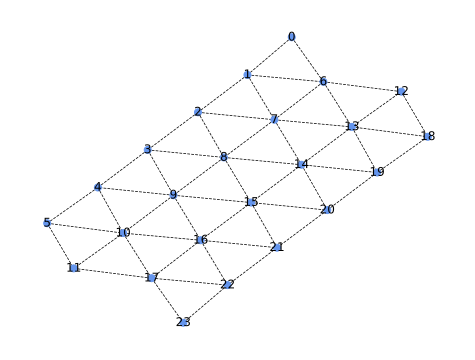

In [20]:
model = getInstance('Heisenberg',cell=TriangularLattice,shape=(2,2))
model.draw_lattice()

In [21]:
model.alpha

183.0

In [22]:
t = 0.25*model.alpha

enc_cos = f_cosine(tau=t,eps=1e-6,precompute=True)
enc_sin = f_sine(tau=t,eps=1e-6,precompute=True)

In [23]:
gate_dynamics    = QSVT_real_polynomial_sum( getEncoding(VALID_ENCODINGS.PauliLCU),instance=model,phis=(enc_cos,enc_sin))


In [24]:
estimate_resources(gate_dynamics)

{'LogicalQubits': 34, 'T': 8464973, 'Clifford': 17377676}

<h5><b>3D Heisenberg Model </b></h5>

We can extend to arbitrary 3d Hamiltonians:

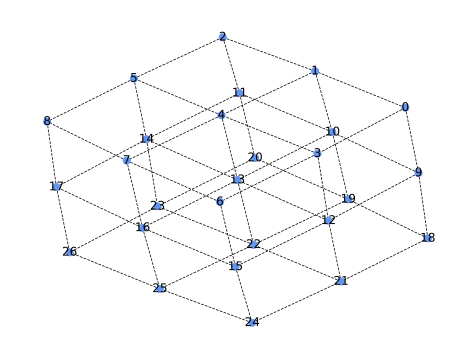

In [25]:
model = getInstance('Heisenberg',cell=CubicLattice,shape=(3,3,3))
model.draw_lattice()

In [26]:
t = 0.25*model.alpha

enc_cos = f_cosine(tau=t,eps=1e-6,precompute=True)
enc_sin = f_sine(tau=t,eps=1e-6,precompute=True)

In [27]:
gate_dynamics    = QSVT_real_polynomial_sum( getEncoding(VALID_ENCODINGS.PauliLCU),instance=model,phis=(enc_cos,enc_sin))

In [28]:
estimate_resources(gate_dynamics)

{'LogicalQubits': 37, 'T': 8680633, 'Clifford': 17820879}

<h5><b>User-Defined Spin Model </b></h5>

Define Hamiltonian terms for 'A' and 'B' sites on a square checkerboard lattice using a term dictionary:

In [29]:
td       =  {}

td['A']  =  [ [ 'Z', 'X' ], [  0.5,  -1.0 ] ]
td['B']  =  [ [ 'Z', 'X' ], [  0.25, -1.0 ] ]

td['AA'] =  [ [ 'ZZ' ], [ 1.0 ] ]
td['BB'] =  [ [ 'ZZ' ], [ 1.0 ] ]
td['AB'] =  [ [ 'ZZ' ], [ 0.5 ] ]



Make model periodic in one of the dimensions, so we are looking at dynamics on a cylinder:

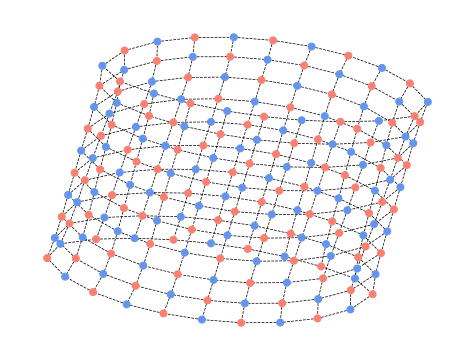

In [30]:

model = LatticeInstance(td=td,shape=(5,10),pbcs=(False,True),cell=SquareLattice,cell_subtype='checkerboard-2')
model.draw_lattice(number_qubits=False)

Total number of lattice sites is:

In [31]:
model.n_qubits()

200

And normalization:

In [32]:
model.alpha

465.0

Generate phases:

In [33]:
t = 0.25*model.alpha

enc_cos = f_cosine(tau=t,eps=1e-6,precompute=True)
enc_sin = f_sine(tau=t,eps=1e-6,precompute=True)

Build sequence and ascertain overhead:

In [34]:
gate_dynamics    = QSVT_real_polynomial_sum( getEncoding(VALID_ENCODINGS.PauliLCU),instance=model,phis=(enc_cos,enc_sin))

Resource overhead:

In [35]:
estimate_resources(gate_dynamics)

{'LogicalQubits': 212, 'T': 75969833, 'Clifford': 155747829}